## 0. Install and Import Dependencies

In [2]:
!pip install easyocr
!pip install imutils


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

import easyocr

## 1. Read in Image, Grayscale and Blur

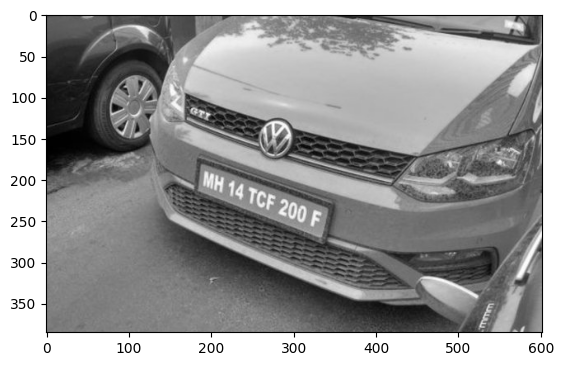

In [13]:
img = cv2.imread('test-nameplate/nameplate2.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

## 2. Apply filter and find edges for localization

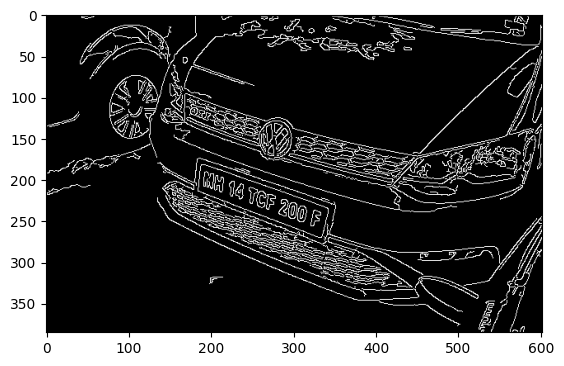

In [14]:
bfilter = cv2.bilateralFilter(gray, 11, 17, 17) #Noise reduction
edged = cv2.Canny(bfilter, 30, 200) #Edge detection
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

## 3. Find Contours and Apply Mask

In [15]:
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(keypoints)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

In [16]:
location = None
for contour in contours:
    approx = cv2.approxPolyDP(contour, 10, True)
    if len(approx) == 4:
        location = approx
        break

In [17]:
location

array([[[188, 182]],

       [[184, 214]],

       [[334, 270]],

       [[341, 234]]], dtype=int32)

In [18]:
mask = np.zeros(gray.shape, np.uint8)
new_image = cv2.drawContours(mask, [location], 0,255, -1)
new_image = cv2.bitwise_and(img, img, mask=mask)

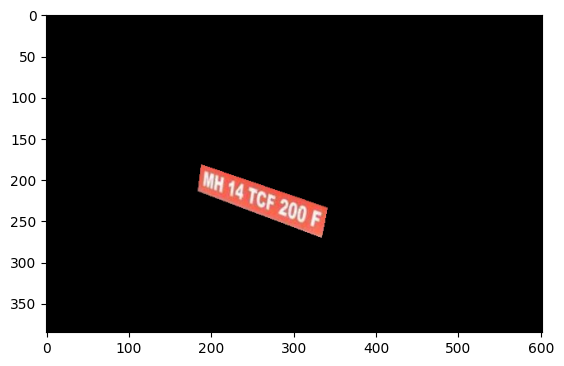

In [19]:
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

In [26]:
(x,y) = np.where(mask==255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
cropped_image = gray[x1:x2+1, y1:y2+1]

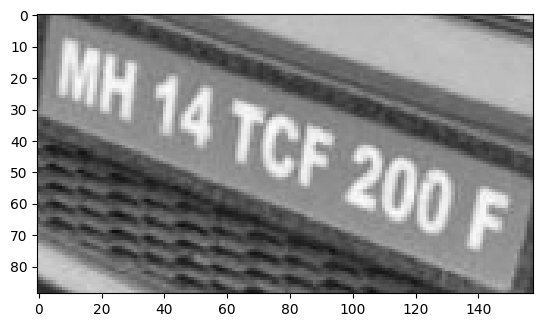

In [21]:
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

## 4. Use Easy OCR To Read Text

In [27]:
reader = easyocr.Reader(['en'])
result = reader.readtext(cropped_image)
result

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[1, 5], [61, 5], [61, 47], [1, 47]], 'MH 14', 0.831581780014743),
 ([[57, 23], [101, 23], [101, 61], [57, 61]], 'TCF', 0.9134575351168291),
 ([[98.18418298355199, 31.08407832104958],
   [162.9733829441328, 54.53931791952083],
   [150.815817016448, 86.91592167895043],
   [86.0266170558672, 63.46068208047917]],
  "'200 F",
  0.36976676624244803)]

In [29]:
data = ""
for item in result:
    data += item[1].replace(" ", "")
data = data.replace("'", "")
data

'MH14TCF200F'

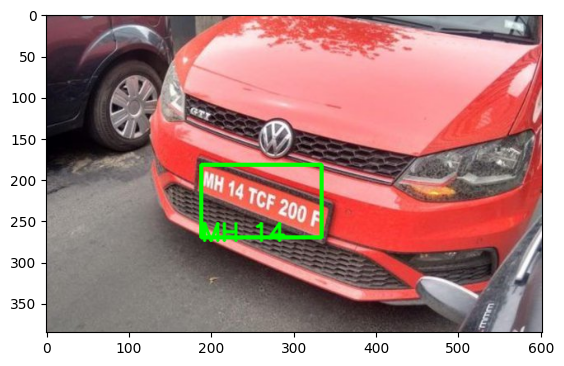

In [28]:
text = result[0][-2]
font = cv2.FONT_HERSHEY_SIMPLEX
res = cv2.putText(img, text=text, org=(approx[0][0][0], approx[1][0][1]+60), fontFace=font, fontScale=1, color=(0,255,0), thickness=2, lineType=cv2.LINE_AA)
res = cv2.rectangle(img, tuple(approx[0][0]), tuple(approx[2][0]), (0,255,0),3)
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))